### Performance Attribution based on Shapley algorithm

In [1]:
from model_builder import model_builder
from data_gen_shapley import simulate_private_equity_cashflows_shapley
import numpy as np
import random
from pme_calc import moic, xirr
import pandas as pd

In [2]:
cashflows = simulate_private_equity_cashflows_shapley()

In [3]:
# Normalize the cashflows of each fund in the market

def fund_weights(cashflows):
    funds = cashflows['FundID'].unique() 
    weights = {}
    for fund in funds:
        fund_cashflows = cashflows[cashflows['FundID'] == fund]
        weights[fund] = -fund_cashflows['Cashflow'].sum()
    return weights

cashflows_contr = cashflows[cashflows['Cashflow'] < 0]
eq_cashflows_contr = fund_weights(cashflows_contr)

def eq_calc(row):
    fund = row['FundID']
    cf = row['Cashflow']
    
    return cf / eq_cashflows_contr[fund]

# Apply the function row-wise
cashflows['eq_cashflow'] = cashflows.apply(eq_calc, axis=1)

# Drop and rename
cashflows = cashflows.drop(columns=['Cashflow']).rename(columns={'eq_cashflow': 'Cashflow'})

cashflows


,FundID,VintageYear,Strategy,Geography,FundQuality,Quarter,date,Cashflow
0,0,1996,Buyout,Rest of World,Good,0,1996-03-31,-0.166800
1,0,1996,Buyout,Rest of World,Good,1,1996-06-30,-0.106916
2,0,1996,Buyout,Rest of World,Good,2,1996-09-30,-0.097514
3,0,1996,Buyout,Rest of World,Good,3,1996-12-31,0.000000
4,0,1996,Buyout,Rest of World,Good,4,1997-03-31,-0.085621
...,...,...,...,...,...,...,...,...
118438,2399,1990,Venture,Rest of World,Bad,36,1999-03-31,0.052860
118439,2399,1990,Venture,Rest of World,Bad,37,1999-06-30,0.021294
118440,2399,1990,Venture,Rest of World,Bad,38,1999-09-30,0.000000
118441,2399,1990,Venture,Rest of World,Bad,39,1999-12-31,0.049056


In [4]:
attributions = []
vintages = cashflows['VintageYear'].unique()
strategies = cashflows['Strategy'].unique()
geos = cashflows['Geography'].unique()

for vintage in vintages:
    for strategy in strategies:
        for geo in geos:
            attributions.append((vintage, strategy, geo))

In [5]:
def permute_list(input_list):
    output_list = input_list.copy()  
    random.shuffle(output_list)
    return output_list

In [6]:
def attribution_irr_changes(attributions, cashflows):
    attribution_values = []

    # Handle the first attribution separately
    first_df = cashflows[
        (cashflows['VintageYear'] == attributions[0][0]) &
        (cashflows['Strategy'] == attributions[0][1]) &
        (cashflows['Geography'] == attributions[0][2])
    ]
    first_aggregated_df = first_df.groupby('date', as_index=False)['Cashflow'].sum()
    first_attribution_irr = xirr(first_aggregated_df['date'], first_aggregated_df['Cashflow'])
    attribution_values.append(first_attribution_irr)

    # Iterate through the rest
    for attrib in attributions[1:]:
        df = cashflows[
            (cashflows['VintageYear'] == attrib[0]) &
            (cashflows['Strategy'] == attrib[1]) &
            (cashflows['Geography'] == attrib[2])
        ]
        first_df = pd.concat([first_df, df], ignore_index=True)  # Keep building the portfolio
        aggregated_df = first_df.groupby('date', as_index=False)['Cashflow'].sum()
        attribution_irr = xirr(aggregated_df['date'], aggregated_df['Cashflow'])
        attribution_values.append(attribution_irr)

    # Calculate incremental IRRs
    final_attribution_values = [attribution_values[0]]
    for i in range(1, len(attribution_values)):
        delta = attribution_values[i] - attribution_values[i-1]
        final_attribution_values.append(delta)

    # Build the output dict
    result = {attrib: value for attrib, value in zip(attributions, final_attribution_values)}
    
    return result


In [7]:
def attribution_moic_changes(attributions, cashflows):
    attribution_values = []

    # Handle the first attribution separately
    first_df = cashflows[
        (cashflows['VintageYear'] == attributions[0][0]) &
        (cashflows['Strategy'] == attributions[0][1]) &
        (cashflows['Geography'] == attributions[0][2])
    ]
    first_aggregated_df = first_df.groupby('date', as_index=False)['Cashflow'].sum()
    first_attribution_irr = moic(first_aggregated_df)
    attribution_values.append(first_attribution_irr)

    # Iterate through the rest
    for attrib in attributions[1:]:
        df = cashflows[
            (cashflows['VintageYear'] == attrib[0]) &
            (cashflows['Strategy'] == attrib[1]) &
            (cashflows['Geography'] == attrib[2])
        ]
        first_df = pd.concat([first_df, df], ignore_index=True)  # Keep building the portfolio
        aggregated_df = first_df.groupby('date', as_index=False)['Cashflow'].sum()
        attribution_irr = moic(aggregated_df)
        attribution_values.append(attribution_irr)

    # Calculate incremental IRRs
    final_attribution_values = [attribution_values[0]]
    for i in range(1, len(attribution_values)):
        delta = attribution_values[i] - attribution_values[i-1]
        final_attribution_values.append(delta)

    # Build the output dict
    result = {attrib: value for attrib, value in zip(attributions, final_attribution_values)}
    
    return result


In [8]:
def shapley_irr(permutated_attributions, cashflows):
    shapley_values = {}
    for attrib in permutated_attributions:
        irr_changes = attribution_irr_changes(attrib, cashflows)
        for key, value in irr_changes.items():
            if key in shapley_values:
                shapley_values[key] += value
            else:
                shapley_values[key] = value 

    average_results = {key: value / len(permutated_attributions) for key, value in shapley_values.items()}
    return average_results

In [9]:
def shapley_moic(permutated_attributions, cashflows):
    shapley_values = {}
    for attrib in permutated_attributions:
        moic_changes = attribution_moic_changes(attrib, cashflows)
        for key, value in moic_changes.items():
            if key in shapley_values:
                shapley_values[key] += value
            else:
                shapley_values[key] = value 

    average_results = {key: value / len(permutated_attributions) for key, value in shapley_values.items()}
    return average_results

### Attribution calculation

In [10]:
permutated_attributions_50 = []
permutated_attributions_100 = []
permutated_attributions_500 = []
permutated_attributions_1000 = []

# numb_of_permutations = 500 # Number of permutations to generate
# for i in range(numb_of_permutations):
#     permutated_attributions.append(permute_list(attributions))

for i in range(50):
    permutated_attributions_50.append(permute_list(attributions))
for i in range(100):
    permutated_attributions_100.append(permute_list(attributions))
for i in range(500):
    permutated_attributions_500.append(permute_list(attributions))
for i in range(1000):
    permutated_attributions_1000.append(permute_list(attributions))

In [11]:
shapley_irr_results_50 = shapley_irr(permutated_attributions_50, cashflows)
shapley_moic_results_50 = shapley_moic(permutated_attributions_50, cashflows)

In [25]:
shapley_irr_results_100 = shapley_irr(permutated_attributions_100, cashflows)
shapley_moic_results_100 = shapley_moic(permutated_attributions_100, cashflows)

In [ ]:
shapley_irr_results_500 = shapley_irr(permutated_attributions_500, cashflows)
shapley_moic_results_500 = shapley_moic(permutated_attributions_500, cashflows)

In [ ]:
shapley_irr_results_1000 = shapley_irr(permutated_attributions_1000, cashflows)
shapley_moic_results_1000 = shapley_moic(permutated_attributions_1000, cashflows)

### Portfolio testing

In [14]:
def portfolio_cashflows(cashflows, portfolio_size):
    
    selected_funds = np.random.choice(cashflows['FundID'].unique(), size=portfolio_size, replace=False)
    portfolio = cashflows[cashflows['FundID'].isin(selected_funds)]

    return portfolio

In [21]:
port_cfs = portfolio_cashflows(cashflows, 200)
port_cfs_contr = port_cfs[port_cfs['Cashflow'] < 0]

In [15]:
def calculate_attribution_weights(port_cfs_contr):
    # Group by the attribution dimensions
    grouped = port_cfs_contr.groupby(['VintageYear', 'Strategy', 'Geography'])['Cashflow'].sum()
    
    # Calculate total contributions
    total_contribution = grouped.sum()
    
    # Calculate weights
    weights = grouped / total_contribution
    
    # Convert back to DataFrame (optional, for easy viewing)
    weights_df = weights.reset_index().rename(columns={'Cashflow': 'Weight'})
    
    return weights_df

In [24]:
weight_df = calculate_attribution_weights(port_cfs_contr)

In [16]:
def weighted_attribution(weights_df, attribution_results):
    weighted_results = {}
    
    for _, row in weights_df.iterrows():
        key = (row['VintageYear'], row['Strategy'], row['Geography'])
        
        if key in attribution_results:
            weighted_value = row['Weight'] * attribution_results[key]
            weighted_results[key] = weighted_value
        else:
            # If some attribution is missing from results, assume 0
            weighted_results[key] = 0
    
    return weighted_results


In [27]:
port_result = weighted_attribution(weight_df, shapley_irr_results)

In [29]:
total_weighted_attribution = sum(port_result.values())
print(total_weighted_attribution*len(shapley_irr_results))

0.10530537930979736


In [30]:
port_aggregated_df = port_cfs.groupby('date', as_index=False)['Cashflow'].sum()
port_irr = xirr(port_aggregated_df['date'], port_aggregated_df['Cashflow'])

In [31]:
port_irr

0.10215310185568714

### Portfolio simulation for residuals

In [17]:
def shapley_simulation(cashflows, shapley_irr_results, type, num_simulations=10, portfolio_size=200):
    results = []
    
    for _ in range(num_simulations):
        # Generate a random portfolio
        portfolio = portfolio_cashflows(cashflows, portfolio_size)
        
        # Calculate the attribution weights for the portfolio
        weights_df = calculate_attribution_weights(portfolio[portfolio['Cashflow'] < 0])
        
        # Calculate the weighted attribution results
        weighted_results = weighted_attribution(weights_df, shapley_irr_results)
        # Calculate the portfolio return
        if type == 'irr':
            port_aggregated_df = portfolio.groupby('date', as_index=False)['Cashflow'].sum()
            port_return = xirr(port_aggregated_df['date'], port_aggregated_df['Cashflow'])
        elif type == 'moic':
            port_aggregated_df = portfolio.groupby('date', as_index=False)['Cashflow'].sum()
            port_return = moic(port_aggregated_df)
        
        # Store the results
        results.append([sum(weighted_results.values())*len(shapley_irr_results), port_return])
    
    return results

In [46]:
moic_result_50 = shapley_simulation(cashflows, shapley_moic_results_50, 'moic', num_simulations=1000, portfolio_size=200)
irr_result_50 = shapley_simulation(cashflows, shapley_irr_results_50, 'irr', num_simulations=1000, portfolio_size=200)

In [47]:
moic_result_100 = shapley_simulation(cashflows, shapley_moic_results_100, 'moic', num_simulations=1000, portfolio_size=200)
irr_result_100 = shapley_simulation(cashflows, shapley_irr_results_100, 'irr', num_simulations=1000, portfolio_size=200)

In [48]:
moic_residual_50 = [a - b for a, b in moic_result_50]
irr_residual_50 = [a - b for a, b in irr_result_50]

In [49]:
moic_residual_100 = [a - b for a, b in moic_result_100]
irr_residual_100 = [a - b for a, b in irr_result_100]

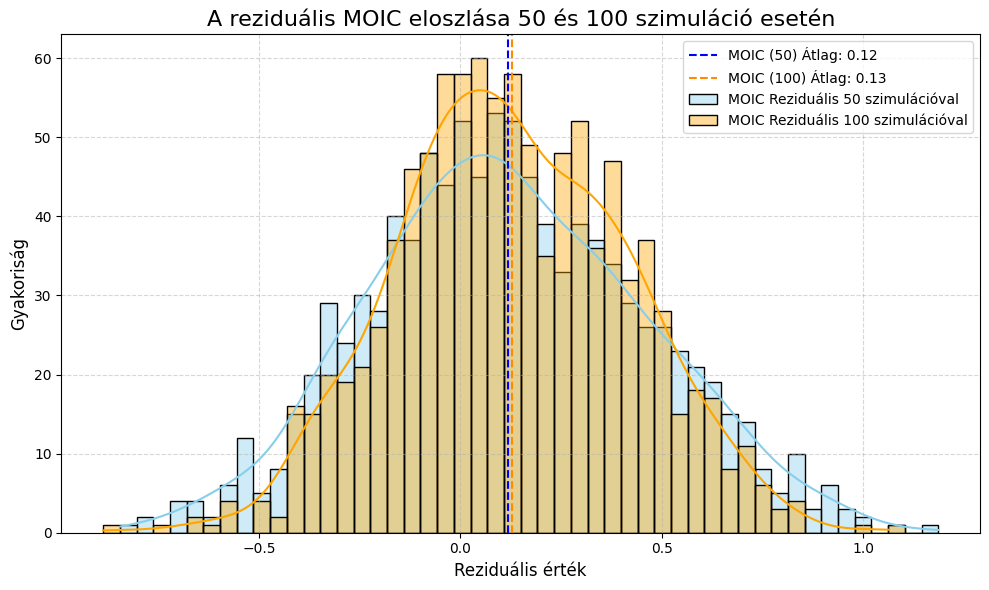

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume moic_residual_50 and moic_residual_100 are your lists
moic_array_50 = np.array(moic_residual_50)
moic_array_100 = np.array(moic_residual_100)

# Determine common bin edges from combined range
combined = np.concatenate([moic_array_50, moic_array_100])
bins = np.histogram_bin_edges(combined, bins=50)

plt.figure(figsize=(10, 6))

# Plot MOIC histogram for 50 simulations
sns.histplot(moic_array_50, bins=bins, kde=True, color='skyblue', edgecolor='black',
             label='MOIC Reziduális 50 szimulációval', alpha=0.4)

# Plot MOIC histogram for 100 simulations
sns.histplot(moic_array_100, bins=bins, kde=True, color='orange', edgecolor='black',
             label='MOIC Reziduális 100 szimulációval', alpha=0.4)

# Add vertical lines for means
plt.axvline(moic_array_50.mean(), color='blue', linestyle='--', linewidth=1.5,
            label=f'MOIC (50) Átlag: {moic_array_50.mean():.2f}')
plt.axvline(moic_array_100.mean(), color='darkorange', linestyle='--', linewidth=1.5,
            label=f'MOIC (100) Átlag: {moic_array_100.mean():.2f}')

# Add titles and labels
plt.title('A reziduális MOIC eloszlása 50 és 100 szimuláció esetén', fontsize=16)
plt.xlabel('Reziduális érték', fontsize=12)
plt.ylabel('Gyakoriság', fontsize=12)
plt.legend()

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# plt.savefig("moic_distr.pdf", format='pdf', bbox_inches='tight')
plt.show()


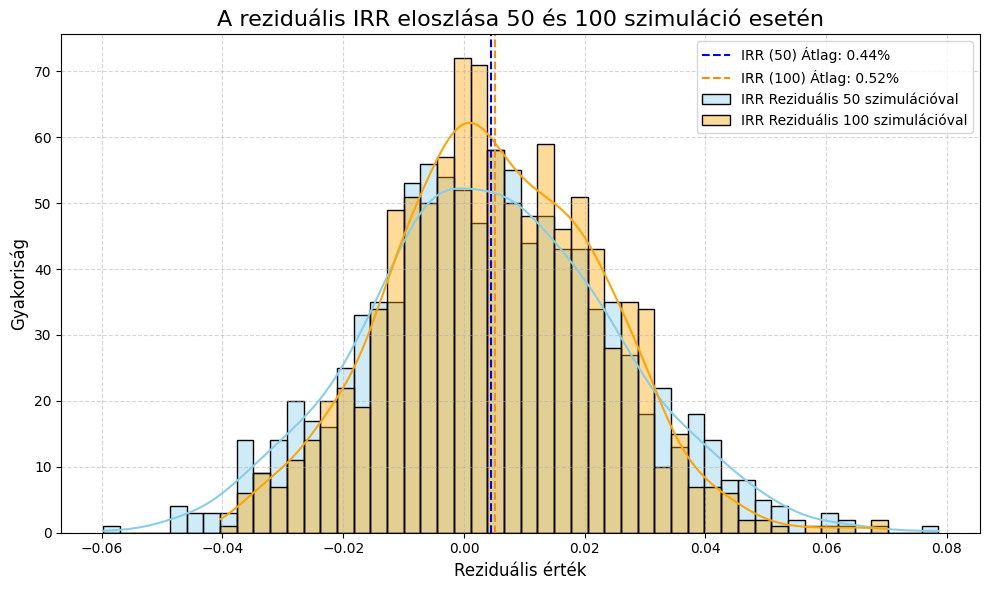

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume moic_residual_50 and moic_residual_100 are your lists
moic_array_50 = np.array(irr_residual_50)
moic_array_100 = np.array(irr_residual_100)

# Determine common bin edges from combined range
combined = np.concatenate([moic_array_50, moic_array_100])
bins = np.histogram_bin_edges(combined, bins=50)

plt.figure(figsize=(10, 6))

# Plot MOIC histogram for 50 simulations
sns.histplot(moic_array_50, bins=bins, kde=True, color='skyblue', edgecolor='black',
             label='IRR Reziduális 50 szimulációval', alpha=0.4)

# Plot MOIC histogram for 100 simulations
sns.histplot(moic_array_100, bins=bins, kde=True, color='orange', edgecolor='black',
             label='IRR Reziduális 100 szimulációval', alpha=0.4)

# Add vertical lines for means
plt.axvline(moic_array_50.mean(), color='blue', linestyle='--', linewidth=1.5,
            label=f'IRR (50) Átlag: {moic_array_50.mean():.2%}')
plt.axvline(moic_array_100.mean(), color='darkorange', linestyle='--', linewidth=1.5,
            label=f'IRR (100) Átlag: {moic_array_100.mean():.2%}')

# Add titles and labels
plt.title('A reziduális IRR eloszlása 50 és 100 szimuláció esetén', fontsize=16)
plt.xlabel('Reziduális érték', fontsize=12)
plt.ylabel('Gyakoriság', fontsize=12)
plt.legend()

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# plt.savefig("moic_distr.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [32]:
# attrribution returns
# plt.bar(range(len(shapley_irr_results)), shapley_irr_results.values(), color='blue', alpha=0.7, edgecolor='black')
# plt.show()

In [33]:
# plt.bar(range(len(shapley_moic_results)), shapley_moic_results.values(), color='blue', alpha=0.7, edgecolor='black')
# plt.show()

### Statistics for the residuals

In [ ]:
s_moic_50 = pd.Series(moic_residual_50)
print(s_moic_50.describe(percentiles=[.05, .25, .5, .75, .95]))

count    1000.000000
mean        0.127556
std         0.285911
min        -0.887263
5%         -0.343165
25%        -0.068224
50%         0.111952
75%         0.329714
95%         0.608807
max         1.063465
dtype: float64


In [58]:
s_moic_100 =pd.Series(moic_residual_100)
print(s_moic_100.describe(percentiles=[.05, .25, .5, .75, .95]))

count    1000.000000
mean        0.127556
std         0.285911
min        -0.887263
5%         -0.343165
25%        -0.068224
50%         0.111952
75%         0.329714
95%         0.608807
max         1.063465
dtype: float64


In [59]:
s_irr_50 = pd.Series(irr_residual_50)
print(s_irr_50.describe(percentiles=[.05, .25, .5, .75, .95]))

count    1000.000000
mean        0.004441
std         0.020614
min        -0.059764
5%         -0.029574
25%        -0.009042
50%         0.004122
75%         0.018213
95%         0.039325
max         0.078559
dtype: float64


In [61]:
s_irr_100 = pd.Series(irr_residual_100)
print(s_irr_100.describe(percentiles=[.05, .25, .5, .75, .95]))

count    1000.000000
mean        0.005209
std         0.017443
min        -0.040343
5%         -0.023543
25%        -0.006791
50%         0.004413
75%         0.017576
95%         0.033061
max         0.070076
dtype: float64


### Individual effects

In [76]:
# Convert to DataFrame
df = pd.DataFrame(
    [(year, strategy, geo, value) for (year, strategy, geo), value in shapley_irr_results_50.items()],
    columns=["Year", "Strategy", "Geography", "Value"]
)
summary = df.groupby(["Geography"])['Value'].sum()
summary

Geography
North America    0.154537
Rest of World   -0.059724
Name: Value, dtype: float64

### Strategy effect

In [77]:
venture_ids = cashflows[cashflows['Strategy'] == 'Venture']['FundID'].unique()
buyout_ids = cashflows[cashflows['Strategy'] == 'Buyout']['FundID'].unique()
venture_ids = np.append(venture_ids,buyout_ids[0]) # we need at least one venture fund to make the model work
buyout_ids = np.append(buyout_ids,venture_ids[0]) # we need at least one buyout fund to make the model work

In [78]:
def portfolio_cashflows_by_id(cashflows, ids):

    # Create a random size adjustment for each selected fund
    size_adjustments = {fund: np.random.uniform(0.5, 2.0) for fund in ids}
    
    # Filter the portfolio
    portfolio = cashflows[cashflows['FundID'].isin(ids)].copy()
    
    # Apply the size adjustment
    portfolio['Cashflow'] = portfolio.apply(lambda row: row['Cashflow'] * size_adjustments[row['FundID']], axis=1)
    
    return portfolio

In [79]:
port_cfs_venture = portfolio_cashflows_by_id(cashflows, venture_ids)
port_cfs_venture = port_cfs_venture.copy()
port_cfs_buyout = portfolio_cashflows_by_id(cashflows, buyout_ids)
port_cfs_buyout = port_cfs_buyout.copy()

In [ ]:
def shapley_simulation_port(portfolio, cashflows, shapley_irr_results, type):

        
    # Calculate the attribution weights for the portfolio
    weights_df = calculate_attribution_weights(portfolio[portfolio['Cashflow'] < 0])
    
    # Calculate the weighted attribution results
    weighted_results = weighted_attribution(weights_df, shapley_irr_results)
    # Calculate the portfolio return
    if type == 'irr':
        port_aggregated_df = portfolio.groupby('date', as_index=False)['Cashflow'].sum()
        port_return = xirr(port_aggregated_df['date'], port_aggregated_df['Cashflow'])
    elif type == 'moic':
        port_aggregated_df = portfolio.groupby('date', as_index=False)['Cashflow'].sum()
        port_return = moic(port_aggregated_df)
        
    
    return 